In [240]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import joblib

In [242]:
df = pd.read_csv("bank-additional-full.csv", sep=";")

In [244]:
df.replace('unknown', np.nan, inplace=True)  # Ganti 'unknown' dengan np.nan, bukan pd.NA
df.drop(columns=['default', 'duration'], inplace=True)
df['y'] = df['y'].map({'yes': 1, 'no': 0})


In [246]:
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)


In [250]:
cat_features = ['job', 'marital', 'education', 'housing', 'loan', 
               'contact', 'month', 'day_of_week', 'poutcome']
num_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
               'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

preprocessor = ColumnTransformer(
    transformers=[
        # Pipeline untuk fitur numerik
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),  # Imputer untuk numerik
        ]), num_features),  # <-- Perhatikan penempatan num_features di sini (di luar Pipeline)
        
        # Pipeline untuk fitur kategori
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputer untuk kategori
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_features)  # <-- cat_features di sini
    ]
)

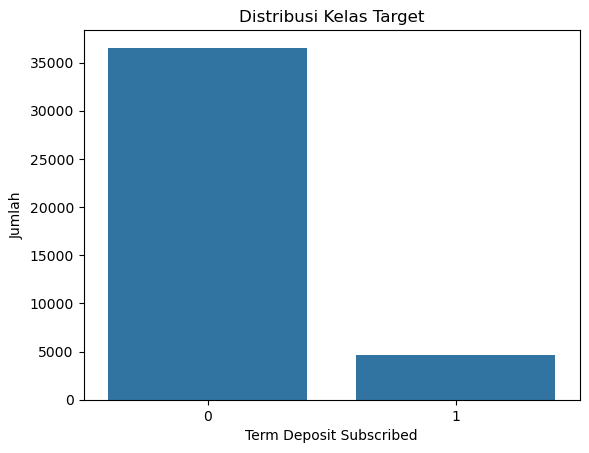

In [252]:
sns.countplot(data=df, x='y')
plt.title('Distribusi Kelas Target')
plt.xlabel('Term Deposit Subscribed')
plt.ylabel('Jumlah')
plt.show()

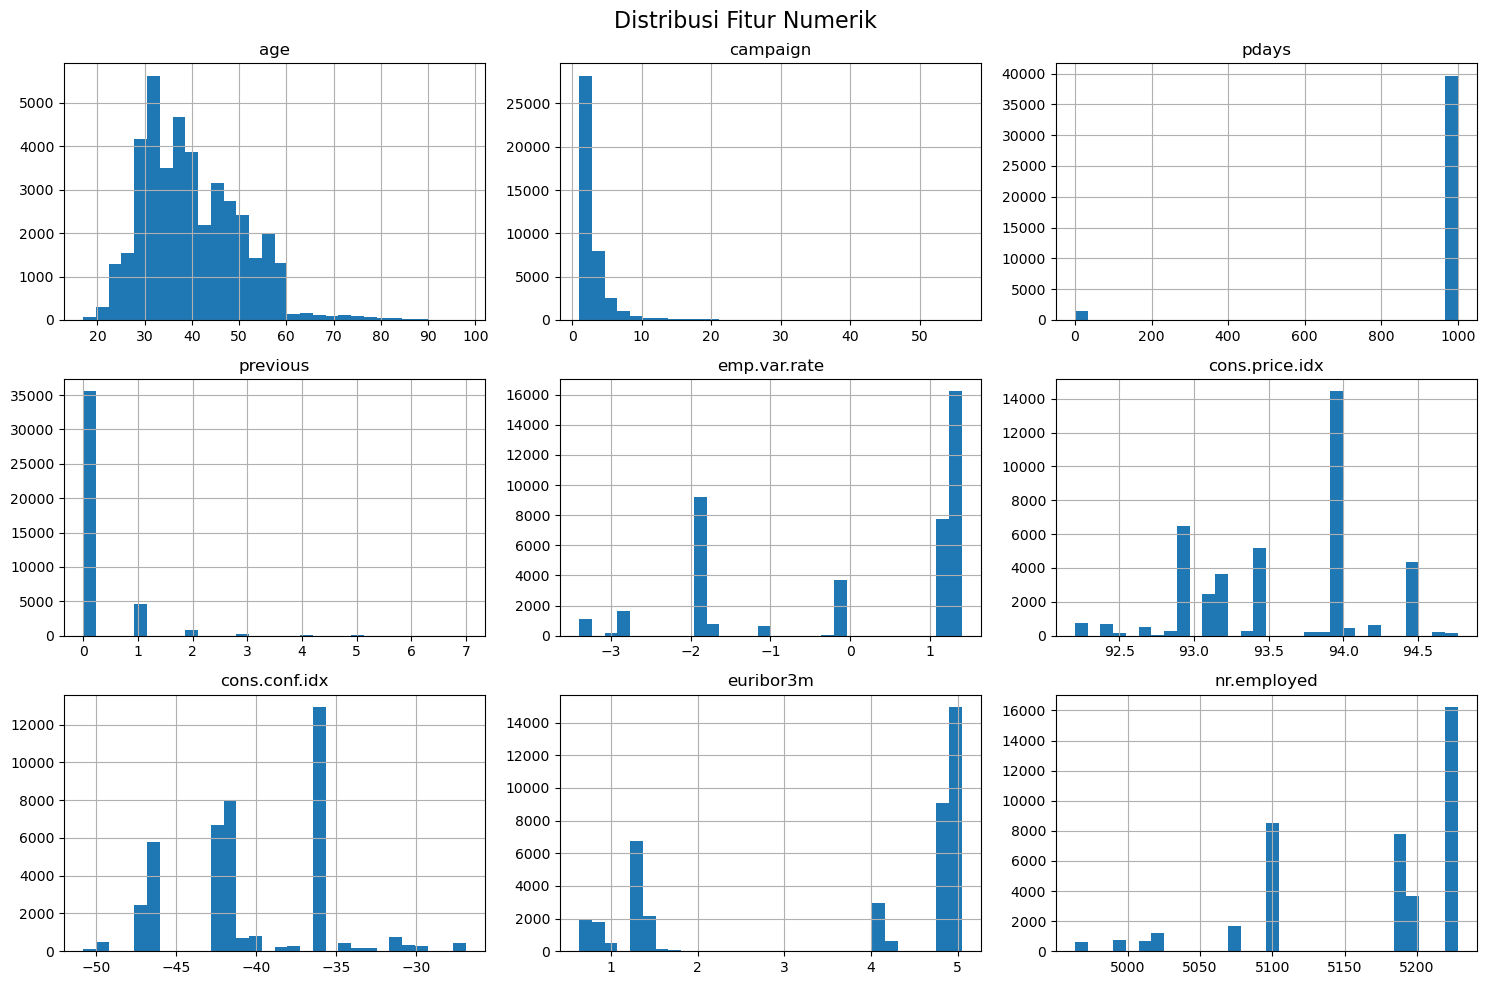

In [254]:
df[num_features].hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Distribusi Fitur Numerik', fontsize=16)
plt.tight_layout()
plt.show()

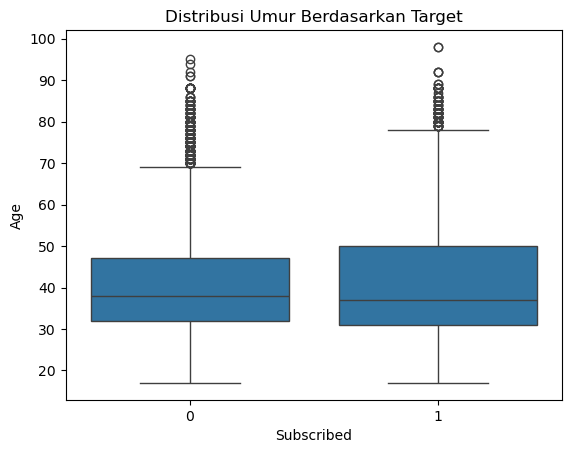

In [256]:
sns.boxplot(data=df, x='y', y='age')
plt.title('Distribusi Umur Berdasarkan Target')
plt.xlabel('Subscribed')
plt.ylabel('Age')
plt.show()

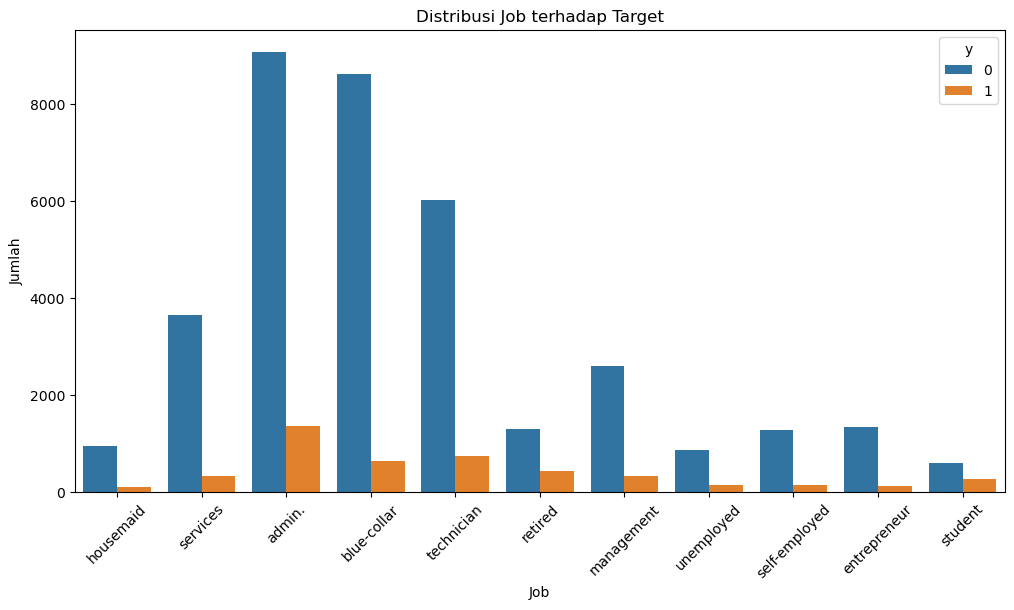

In [258]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='job', hue='y')
plt.title('Distribusi Job terhadap Target')
plt.xticks(rotation=45)
plt.xlabel('Job')
plt.ylabel('Jumlah')
plt.show()

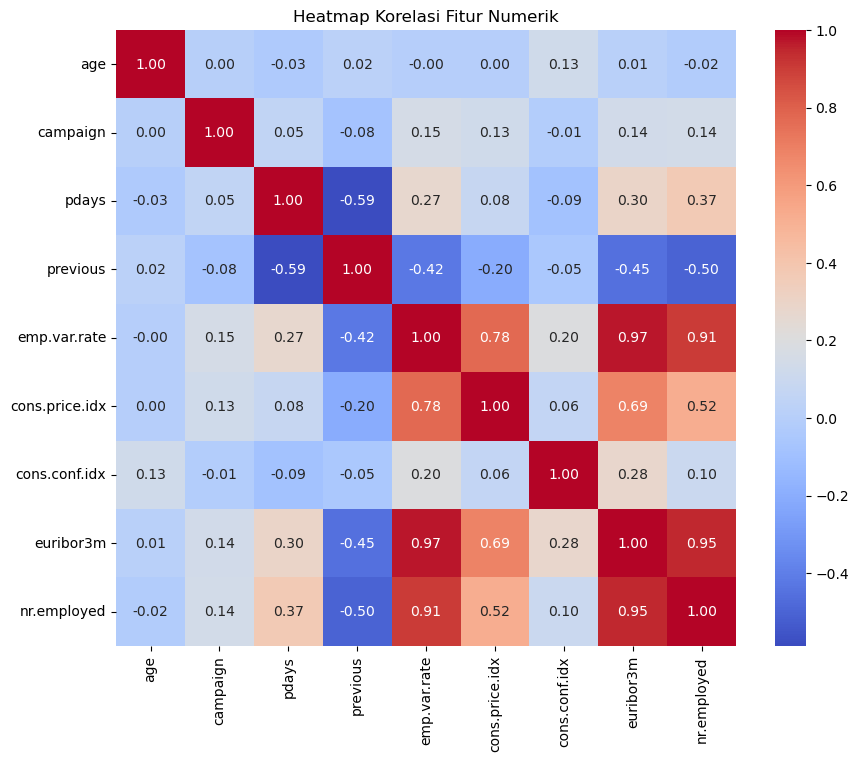

In [260]:
plt.figure(figsize=(10, 8))
corr = df[num_features].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

In [57]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=1000
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print(f"Akurasi: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.2f}")
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
Akurasi: 0.90
ROC-AUC: 0.78
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7310
           1       0.57      0.30      0.39       928

    accuracy                           0.90      8238
   macro avg       0.74      0.64      0.67      8238
weighted avg       0.88      0.90      0.88      8238



In [55]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print(f"Akurasi: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lr):.2f}")
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
Akurasi: 0.83
ROC-AUC: 0.80
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7310
           1       0.36      0.64      0.46       928

    accuracy                           0.83      8238
   macro avg       0.65      0.75      0.68      8238
weighted avg       0.88      0.83      0.85      8238



C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            class_weight='balanced',
            random_state=42
        ))
    ]),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Hasil GridSearchCV ===")
print("Parameter Terbaik:", grid_search.best_params_)
print("ROC-AUC Terbaik:", grid_search.best_score_)


=== Hasil GridSearchCV ===
Parameter Terbaik: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
ROC-AUC Terbaik: 0.7951161612363834


In [63]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\n=== Model Terbaik ===")
print(f"Akurasi: {accuracy_score(y_test, y_pred_best):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_best):.2f}")
print(classification_report(y_test, y_pred_best))


=== Model Terbaik ===
Akurasi: 0.86
ROC-AUC: 0.81
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7310
           1       0.43      0.63      0.51       928

    accuracy                           0.86      8238
   macro avg       0.69      0.76      0.71      8238
weighted avg       0.89      0.86      0.87      8238



In [65]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [221]:
# Load model
loaded_model = joblib.load('best_model.pkl')

# Data baru
new_data = pd.DataFrame([{
    'age': 44,
    'job': 'services',
    'marital': 'single',
    'education': 'high.schol',
    'default': 'no',
    'housing': 'yes',
    'loan': 'yes',
    'contact': 'cellular',
    'month': 'apr',
    'day_of_week': 'tue',
    'campaign': 1,
    'pdays': 999,  # Nilai default untuk "tidak ada kontak sebelumnya"
    'previous': 0,
    'poutcome': 'nonexistent',
    'emp.var.rate': -1.8,
    'cons.price.idx': 93.075,        # Penurunan employment variance (resesi)
    'cons.conf.idx': -47.1,      # Krisis kepercayaan konsumen
    'euribor3m': 1.453,            # Tingkat bunga rendah
    'nr.employed': 5099.1
}])

# Prediksi
prediction = loaded_model.predict(new_data)
probability = loaded_model.predict_proba(new_data)[:, 1]

# Tampilkan hasil
print(f"Prediksi: {'Akan berlangganan' if prediction[0] == 1 else 'Tidak akan berlangganan'}")
print(f"Probabilitas: {probability[0]:.2%}")

Prediksi: Akan berlangganan
Probabilitas: 58.50%


In [236]:
new_data = X_test.iloc[0:4]  # Ambil 1 contoh data dari X_test
prediction = loaded_model.predict(new_data)
print(f"Prediksi: {prediction}")


Prediksi: [0 1 1 0]
